In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split as tts
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

#### load data

In [2]:
### data of scores
first=True
for year in range(2015, 2021):
    cur_df = pd.read_csv('no_gender_{}.csv'.format(year))
    if year < 2017:
        cur_df['before2017']=1
    else:
        cur_df['before2017']=0
    cur_df['year']=year
    if first:
        full_df = cur_df.copy()
        first=False
    else:
        full_df = pd.concat([full_df, cur_df], axis=0).reset_index(drop=True)

#### prepocess data

In [3]:
### clean scores
scored_df = full_df.copy()
scored_df['Score'] = pd.to_numeric(scored_df['Score'], errors='coerce')
scored_df.dropna(subset=['Score'], inplace=True)

In [4]:
scored_df['Score_norm'] = scored_df['Score']/140
scored_df.loc[scored_df['before2017']==1, 'Score_norm'] = scored_df.loc[scored_df['before2017']==1, 'Score'] / 100

In [5]:
def get_specialization_code(code_name):
    code_name = str(code_name)
    if '-' not in code_name:
        if code_name[:1]=='5':
            return code_name.split(' ')[0].strip()
        else:
            return None
    else:
        return code_name.split('-')[0].strip()

In [6]:
### get specialization codes
coded_df = scored_df.copy()
coded_df['SpecCode'] = coded_df['Specialization'].apply(get_specialization_code)

In [7]:
### how much nan codes
coded_df['SpecCode'].isna().sum(), coded_df.shape[0]

(1165, 193097)

In [8]:
### values of specialization without codes
coded_df[coded_df['SpecCode'].isna()]['Specialization'].unique()

array(['Білім', 'Гуманитарлық ғылымдар', 'Құқық', 'Өнер',
       'Әлеуметтік ғылымдар, экономика және бизнес',
       'Жаратылыстану ғылымдары',
       'Техникалық ғылымдар және технологиялар',
       'Ауылшаруашылық ғылымдары', 'Қызмет көрсету',
       'Денсаулық сақтау және әлеуметтік қамтамасыз ету (медицина)',
       'Ветеринария', 'ҚазҰМУ 13', 'ОҚМФА 11', 'ОҚМФА 13', 'Астана МУ 13',
       'ҚарММУ 13', 'ҚА', 'ҚазҰМУ 11', '№', 'Күндізгі оқу түрі'],
      dtype=object)

In [9]:
### drop nans
coded_df.dropna(subset=['SpecCode'], inplace=True)

In [10]:
### clean uni codes
uni_df = coded_df.copy()
uni_df['University Code'] = pd.to_numeric(uni_df['University Code'], errors='coerce')
uni_df.dropna(subset=['University Code'], inplace=True)

In [11]:
def gender_from_name(text):
    lower_text = str(text).lower()
    if ('қызы' in lower_text
        or 'кызы' in lower_text
        or 'ова' in lower_text
        or 'овна' in lower_text
       or 'евна' in lower_text
       or 'кизи' in lower_text
       or 'қизи' in lower_text):
        gender = 'female'
    elif ('ұлы' in lower_text
          or 'улы' in lower_text
          or 'ович' in lower_text
         or 'евич' in lower_text):
        gender = 'male'
    else:
        gender = None
    return gender

In [12]:
### get genders
gendered_df = uni_df.copy()
gendered_df['Gender'] = gendered_df['Name'].apply(gender_from_name)
gendered_df.dropna(subset=['Gender'], inplace=True)

In [13]:
### encode categorical values
categories = ['University Code', 'Competition', 'SpecCode', 'Gender']
ohe = OneHotEncoder(drop='first', sparse=False)
encoded_data = ohe.fit_transform(gendered_df[categories])
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out())
encoded_df['before2017'] = gendered_df['before2017'].tolist()
encoded_df['Score'] = gendered_df['Score_norm'].tolist()

/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### make train test split

In [14]:
### feature target split
x = encoded_df.drop(columns=['Gender_male'])
y = encoded_df['Gender_male']
for col in x.columns:
    x[col] = x[col].astype('float')

In [15]:
### train test split
x_tr, x_t, y_tr, y_t = tts(x, y, test_size=0.2, random_state=105)

#### with uni codes

In [16]:
### prep conditions
param_grid = {'C': np.arange(0.1, 2.1, 0.1)}
LR = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
grid_search = GridSearchCV(LR, param_grid, cv=3, scoring='f1', n_jobs=-1)

In [17]:
### train model
grid_search.fit(x_tr, y_tr)

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=1000, penalty='l1',
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])},
             scoring='f1')

In [18]:
### check model scores
pred_tr = grid_search.predict(x_tr)
print(classification_report(y_tr, pred_tr))

              precision    recall  f1-score   support

         0.0       0.76      0.79      0.77     84193
         1.0       0.71      0.67      0.69     64775

    accuracy                           0.74    148968
   macro avg       0.73      0.73      0.73    148968
weighted avg       0.74      0.74      0.74    148968



In [19]:
### check best configuration of model
grid_search.best_params_

{'C': 2.0}

In [20]:
coef_importance = {grid_search.best_estimator_.feature_names_in_[i]: grid_search.best_estimator_.coef_[0][i] for i in range(len(grid_search.best_estimator_.feature_names_in_))}
coef_importance = dict(sorted(coef_importance.items(), reverse=True, key=lambda x: abs(x[1])))

In [21]:
truly_important = {key: val for key,val in coef_importance.items() if abs(val) >= 0.01}

In [22]:
neat_model = sm.Logit(y_tr, x_tr[truly_important.keys()]).fit(maxiter=5000, start_params=list(truly_important.values()), method='nm')
print(neat_model.summary())

/Users/user/Library/Python/3.8/lib/python/site-packages/statsmodels/base/optimizer.py:736: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/Users/user/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Gender_male   No. Observations:               148968
Model:                          Logit   Df Residuals:                   148596
Method:                           MLE   Df Model:                          371
Date:                Fri, 31 May 2024   Pseudo R-squ.:                  0.1562
Time:                        04:57:53   Log-Likelihood:                -86058.
converged:                      False   LL-Null:                   -1.0199e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
University Code_25.0         -7.0527      1.020     -6.914      0.000      -9.052      -5.054
SpecCode_5B010100            -5.5318      0.585     -9.449      0.000      -6.679     

In [23]:
y_pred_proba = neat_model.predict(x_t[truly_important.keys()])
y_pred = (y_pred_proba>=0.5).astype(int)
print('test sample')
print(classification_report(y_t, y_pred))
y_pred_proba = neat_model.predict(x_tr[truly_important.keys()])
y_pred = (y_pred_proba>=0.5).astype(int)
print('train sample')
print(classification_report(y_tr, y_pred))

test sample
              precision    recall  f1-score   support

         0.0       0.81      0.65      0.72     21076
         1.0       0.64      0.80      0.71     16167

    accuracy                           0.72     37243
   macro avg       0.72      0.73      0.72     37243
weighted avg       0.73      0.72      0.72     37243

train sample
              precision    recall  f1-score   support

         0.0       0.81      0.65      0.72     84193
         1.0       0.64      0.80      0.71     64775

    accuracy                           0.71    148968
   macro avg       0.72      0.72      0.71    148968
weighted avg       0.73      0.71      0.71    148968



In [24]:
pvals_dict = dict(neat_model.pvalues)
coefs_dict = dict(neat_model.params)
spec_dict = {row['SpecCode']: row['Specialization'] for i,row in gendered_df[['Specialization', 'SpecCode']].drop_duplicates().iterrows()}

In [25]:
important_feats = {}
for feat, coef in coefs_dict.items():
    if abs(coef)<1:
        continue
    if 'SpecCode_' in feat:
        spec_code = feat[9:]
        spec_name = spec_dict[spec_code]
        feat_p = pvals_dict[feat]
        if feat_p > 0.05:
            print('{} is important but not stat significant'.format(spec_name))
            continue
        else:
            important_feats[spec_name] = coef
    else:
        feat_p = pvals_dict[feat]
        if feat_p > 0.05:
            print('{} is important but not stat significant'.format(feat))
            continue
        else:
            important_feats[feat] = coef
important_feats = dict(sorted(important_feats.items(), reverse=True, key=lambda x: abs(x[1])))

University Code_989.0 is important but not stat significant
5B021022 - Шетел филологиясы: француз тілі is important but not stat significant
24.05.03 - Ұшатын аппараттарды сынау is important but not stat significant
University Code_17.0 is important but not stat significant
B171 - Металлургия is important but not stat significant


In [26]:
important_feats

{'University Code_25.0': -7.0527087275027895,
 '5B010100 - Мектепке дейінгі оқыту және тәрбиелеу': -5.5318247609286,
 'B002 - Дошкольное обучение и воспитание': -3.9279476195863783,
 '5B010200 - Бастауышта оқыту педагогикасы мен әдістемесі': -3.426184401265468,
 'B003 - Педагогика и методика начального обучения': -3.2547820904030296,
 'B028 - Хореография': -3.2280902110811667,
 '5B021015 - Шетел филологиясы: корей тілі': -2.7943336239508394,
 '5B071800 - Электр энергетикасы': 2.7093853602671683,
 'B162 - Теплоэнергетика': 2.6928578394502765,
 'B020 - Специальная педагогика': -2.6779163495031106,
 'B167 - Летная эксплуатация летательных аппаратов и двигателей': 2.6742415662201253,
 'B065 - Автотранспортные средства': 2.600126634601578,
 '5B071200 - Машина жасау': 2.5869396710254033,
 '5B074300 - Ұшатын аппараттар мен қозғалтқыштарды ұшуда пайдалану': 2.5408820304043953,
 '5B021014 - Шетел филологиясы: түрік тілі': -2.512000625252969,
 '5B021019 - Шетел филологиясы: өзбек тілі': -2.50993

In [27]:
len(important_feats)

114

In [28]:
important_specs = {}
stat_insign = []
for feat, coef in coefs_dict.items():
    if 'SpecCode_' not in feat:
        continue
    spec_code = feat[9:]
    spec_name = spec_dict[spec_code]
    feat_p = pvals_dict[feat]
    if feat_p > 0.05:
        print('{} is not stat significant'.format(spec_name))
        stat_insign.append(spec_name)
        continue
    else:
        important_specs[spec_name] = coef
important_specs = dict(sorted(important_specs.items(), reverse=True, key=lambda x: abs(x[1])))

5B021022 - Шетел филологиясы: француз тілі is not stat significant
5B040900 - Хореография is not stat significant
24.05.03 - Ұшатын аппараттарды сынау is not stat significant
B171 - Металлургия is not stat significant
5B021021 - Шетел филологиясы: үнді тілі (хинди, урду) is not stat significant
5B075000 - Метрология is not stat significant
5В100200 Ақпараттық қауіпсіздік жүйелері is not stat significant
38.03.02 - Менеджмент is not stat significant
5В011200 - Химия is not stat significant
B048 - Трудовые навыки is not stat significant
5B021020 - Шетел филологиясы: ұйғыр тілі is not stat significant
5B011924 - Шетел тілі: екі шетел тілі (француз тілі) is not stat significant
5B021018 - Шетел филологиясы: парсы тілі is not stat significant
5B072200 - Полиграфия is not stat significant
B021 - Исполнительское искусство is not stat significant
5B030300 - Құқық қорғау қызметі is not stat significant
5B075300 - Балқуы қиын бейметалл және силикатты материалдардың химиялық технологиясы is not s

In [29]:
len(important_specs)

204

#### find best cut

In [30]:
male_feats = dict(sorted(important_specs.items(), reverse=True, key=lambda x: x[1]))
total_specs = []
fscores = []
for i in range(len(male_feats)):
    total_specs.append(list(male_feats.keys())[i])
    true_male = gendered_df[(gendered_df['Specialization'].isin(total_specs)) & (gendered_df['Gender']=='male')].shape[0]
    false_male = gendered_df[(gendered_df['Specialization'].isin(total_specs)) & (gendered_df['Gender']=='female')].shape[0]
    false_female = gendered_df[(~gendered_df['Specialization'].isin(total_specs)) & (gendered_df['Gender']=='male')].shape[0]
    precision = true_male / (true_male+false_male)
    recall = true_male / (true_male+false_female)
    fscore = 2*precision*recall/(precision+recall)
    fscores.append(fscore)

In [31]:
max_fscore = max(fscores)
max_ind = fscores.index(max_fscore)
best_cutoff = list(male_feats.values())[max_ind]

In [32]:
best_cutoff

0.16886956709003986

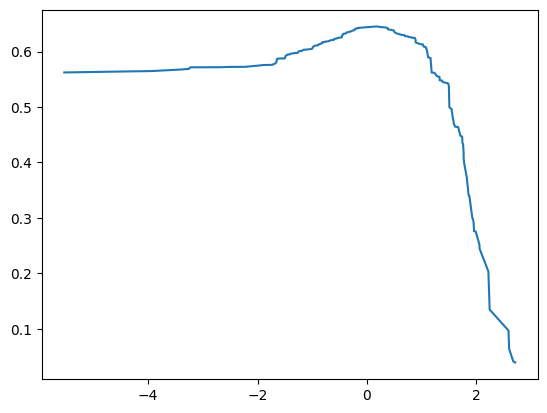

In [33]:
plt.plot(male_feats.values(), fscores)
plt.show()

In [34]:
female_feats = dict(sorted(important_specs.items(), reverse=False, key=lambda x: x[1]))
total_specs = []
fscores = []
for i in range(len(female_feats)):
    total_specs.append(list(female_feats.keys())[i])
    true_female = gendered_df[(gendered_df['Specialization'].isin(total_specs)) & (gendered_df['Gender']=='female')].shape[0]
    false_female = gendered_df[(gendered_df['Specialization'].isin(total_specs)) & (gendered_df['Gender']=='male')].shape[0]
    false_male = gendered_df[(~gendered_df['Specialization'].isin(total_specs)) & (gendered_df['Gender']=='female')].shape[0]
    precision = true_female / (true_female+false_female)
    recall = true_female / (true_female+false_male)
    fscore = 2*precision*recall/(precision+recall)
    fscores.append(fscore)

In [35]:
max_fscore = max(fscores)
max_ind = fscores.index(max_fscore)
best_cutoff = list(female_feats.values())[max_ind]

In [36]:
best_cutoff

1.3020968011486396

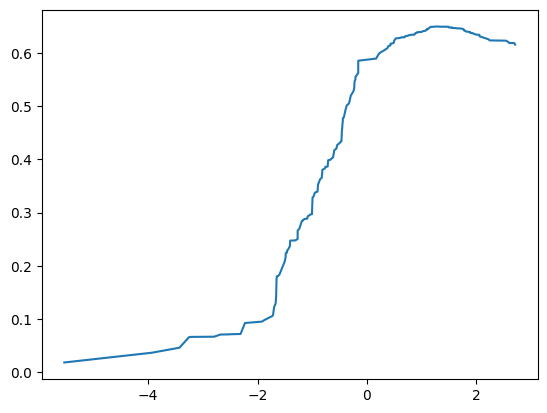

In [37]:
plt.plot(female_feats.values(), fscores)
plt.show()

#### male female feats distribution

In [38]:
top_male_specs = [key for key,val in important_specs.items() if val>=0.16777846471067243]
top_feamale_specs = [key for key,val in important_specs.items() if val<0]

In [39]:
top_male_specs

['5B071800 - Электр энергетикасы',
 'B162 - Теплоэнергетика',
 'B167 - Летная эксплуатация летательных аппаратов и двигателей',
 'B065 - Автотранспортные средства',
 '5B071200 - Машина жасау',
 '5B074300 - Ұшатын аппараттар мен қозғалтқыштарды ұшуда пайдалану',
 '5B071300 - Көлік, көліктік техника және технологиялар',
 'B062 - Электротехника и энергетика',
 'B064 - Механика и металлообработка',
 '5B074500 - Көлік құрылысы',
 '5B072400 - Технологиялық машиналар және жабдықтар (сала бойынша)',
 '5В071500 - Теңіз техникасы және технологиясы',
 '5B071700 - Жылу энергетикасы',
 '5B100200 - Ақпараттық қауіпсіздік жүйелері',
 'B271 - Нефтегазовое дело',
 'B063 - Электротехника и автоматизация',
 '5В060200 Информатика',
 '5B070700 - Тау-кен ісі',
 'B004 - Подготовка учителей начальной военной подготовки',
 'B071 - Горное дело и добыча полезных ископаемых',
 '5B070200 - Автоматтандыру және басқару',
 '5B081200 - Ауыл шаруашылығын энергиямен қамтамасыз ету',
 'B005 - Подготовка учителей физическ

In [40]:
top_feamale_specs

['5B010100 - Мектепке дейінгі оқыту және тәрбиелеу',
 'B002 - Дошкольное обучение и воспитание',
 '5B010200 - Бастауышта оқыту педагогикасы мен әдістемесі',
 'B003 - Педагогика и методика начального обучения',
 'B028 - Хореография',
 '5B021015 - Шетел филологиясы: корей тілі',
 'B020 - Специальная педагогика',
 '5B021014 - Шетел филологиясы: түрік тілі',
 '5B021019 - Шетел филологиясы: өзбек тілі',
 '5B020726 - Аударма ісі (қазақ тілінен басқа тілдерге және керісінше синхроншы-аудармашылар)',
 '5B010500 - Дефектология',
 '5B021000 - Шетел филологиясы: ағылшын тілі',
 '5В050400 Журналистика',
 '5B012100 - Қазақ тілінде оқытпайтын мектептердегі қазақ тілі мен әдебиеті',
 '5B010300 - Педагогика және психология',
 '5B110100 - Мейірбике ісі',
 'B013 - Подготовка учителей биологии',
 '5B011800 - Орыс тілі мен әдебиеті',
 'B017 - Подготовка учителей русского языка и литературы',
 'B018 - Подготовка учителей иностранного языка',
 'B001 - Педагогика и психология',
 '5B041700 - Сән өнері',
 'B03

In [41]:
len(spec_dict), len(top_feamale_specs), len(top_male_specs)

(294, 97, 107)

In [42]:
gendered_df[gendered_df['Specialization'].isin(top_male_specs)]['Gender'].value_counts()

Gender
male      51067
female    26238
Name: count, dtype: int64

In [43]:
gendered_df[gendered_df['Specialization'].isin(top_feamale_specs)]['Gender'].value_counts()

Gender
female    47437
male       9426
Name: count, dtype: int64

In [44]:
gendered_df[(~gendered_df['Specialization'].isin(top_feamale_specs))&(~gendered_df['Specialization'].isin(top_male_specs))]['Gender'].value_counts()

Gender
female    31594
male      20449
Name: count, dtype: int64

In [45]:
gendered_df['Gender'].value_counts()

Gender
female    105269
male       80942
Name: count, dtype: int64

#### perdict at each year

In [46]:
spec_df = gendered_df.copy()

In [47]:
spec_df['male_specialization']=0
spec_df.loc[spec_df['Specialization'].isin(top_male_specs), 'male_specialization']=1

In [48]:
spec_df['female_specialization']=0
spec_df.loc[spec_df['Specialization'].isin(top_feamale_specs), 'female_specialization']=1

In [49]:
spec_df['Competition'].value_counts()

Competition
general          156158
village quota     30053
Name: count, dtype: int64

In [50]:
spec_df['general_competition']=0
spec_df.loc[spec_df['Competition']=='general', 'general_competition']=1

In [51]:
spec_df['is_male'] = 0
spec_df.loc[spec_df['Gender']=='male', 'is_male']=1

In [52]:
spec_df

,No,Code,Name,Score,University Code,Competition,Specialization,before2017,year,Score_norm,SpecCode,Gender,male_specialization,female_specialization,general_competition,is_male
0,1,045009111,Құлыбек Арайлым Сәрсенбекқызы,94.0,45.0,general,5B010100 - Дошкольное обучение и воспитание,1,2015,0.940000,5B010100,female,0,0,1,0
1,2,029005329,Турашбек Динара Тимурқызы,94.0,34.0,general,5B010100 - Дошкольное обучение и воспитание,1,2015,0.940000,5B010100,female,0,0,1,0
2,3,011002093,Базарбаева Анар Әлібекқызы,91.0,11.0,general,5B010100 - Дошкольное обучение и воспитание,1,2015,0.910000,5B010100,female,0,0,1,0
3,4,747003006,Мағзумова Аида Жанабайқызы,90.0,11.0,general,5B010100 - Дошкольное обучение и воспитание,1,2015,0.900000,5B010100,female,0,0,1,0
4,5,010016051,Мухитова Слу Жанболатовна,90.0,10.0,general,5B010100 - Дошкольное обучение и воспитание,1,2015,0.900000,5B010100,female,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193760,11,16300047,КУСАЙНОВА ДИЛЬНАЗ ТЕМУРОВНА,76.0,16.0,general,B013 - Подготовка учителей биологии,0,2020,0.542857,B013,female,0,1,1,0
193761,12,25300035,ЕРТАЕВА ДИЛЬНАЗ БЕРІКҚЫЗЫ,76.0,15.0,general,B013 - Подготовка учителей биологии,0,2020,0.542857,B013,female,0,1,1,0
193762,13,196300005,ИСМАЙЛ ГҮЛДАНА САҒЫНТАЙҚЫЗЫ,74.0,196.0,general,B013 - Подготовка учителей биологии,0,2020,0.528571,B013,female,0,1,1,0
193763,14,25300043,АНАРБЕКҚЫЗЫ БОТАГӨЗ,74.0,25.0,general,B013 - Подготовка учителей биологии,0,2020,0.528571,B013,female,0,1,1,0


In [53]:
def get_analysis(year, show_summary=False, show_accuracy=True):
    cur_df = spec_df[spec_df['year']==year].reset_index(drop=True)
    x = cur_df[['Score_norm', 'male_specialization', 'female_specialization', 'general_competition']].copy()
    y = cur_df['is_male']
    x_tr, x_t, y_tr, y_t = tts(x, y, test_size=0.2, random_state=105)
    neat_model = sm.Logit(y_tr, x_tr).fit(maxiter=1000, method='nm')
    if show_summary:
        y_pred_proba = neat_model.predict(x_t)
        y_pred = (y_pred_proba>=0.5).astype(int)
        print('test sample')
        print(classification_report(y_t, y_pred))
        y_pred_proba = neat_model.predict(x_tr)
        y_pred = (y_pred_proba>=0.5).astype(int)
        print('train sample')
        print(classification_report(y_tr, y_pred))
    if show_accuracy:
        y_pred_proba = neat_model.predict(x_t)
        y_pred = (y_pred_proba>=0.5).astype(int)
        print('test accuracy:', accuracy_score(y_t, y_pred))
    return neat_model

In [54]:
model2015 = get_analysis(2015)
model2015.summary()

Optimization terminated successfully.
         Current function value: 0.666605
         Iterations: 357
         Function evaluations: 591
test accuracy: 0.5855513307984791


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_male   No. Observations:                15777
Model:                          Logit   Df Residuals:                    15773
Method:                           MLE   Df Model:                            3
Date:                Fri, 31 May 2024   Pseudo R-squ.:                 0.01942
Time:                        04:58:43   Log-Likelihood:                -10517.
converged:                       True   LL-Null:                       -10725.
Covariance Type:            nonrobust   LLR p-value:                 5.425e-90
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Score_norm               -0.5277      0.041    -12.966      0.000      -0.607      -0.448
male_specialization       0.1890      0.062      3.063      0.002       0.068       0.310
female_specialization    -1.2079      0.074    -16.326      0.000      -1.353      -1.063
general_competition       0.2487      0.040      6.146      0.000       0.169       0.328
=========================================================================================
"""

In [55]:
model2016 = get_analysis(2016)
model2016.summary()

Optimization terminated successfully.
         Current function value: 0.591432
         Iterations: 241
         Function evaluations: 409
test accuracy: 0.6900664841611264


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_male   No. Observations:                20454
Model:                          Logit   Df Residuals:                    20450
Method:                           MLE   Df Model:                            3
Date:                Fri, 31 May 2024   Pseudo R-squ.:                  0.1330
Time:                        04:58:44   Log-Likelihood:                -12097.
converged:                       True   LL-Null:                       -13953.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Score_norm               -0.6746      0.049    -13.686      0.000      -0.771      -0.578
male_specialization       1.0145      0.033     30.519      0.000       0.949       1.080
female_specialization    -1.3740      0.049    -28.000      0.000      -1.470      -1.278
general_competition       0.0396      0.043      0.929      0.353      -0.044       0.123
=========================================================================================
"""

In [56]:
model2017 = get_analysis(2017)
model2017.summary()

Optimization terminated successfully.
         Current function value: 0.590859
         Iterations: 304
         Function evaluations: 514
test accuracy: 0.6965408805031447


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_male   No. Observations:                20349
Model:                          Logit   Df Residuals:                    20345
Method:                           MLE   Df Model:                            3
Date:                Fri, 31 May 2024   Pseudo R-squ.:                  0.1373
Time:                        04:58:45   Log-Likelihood:                -12023.
converged:                       True   LL-Null:                       -13938.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Score_norm               -0.7296      0.052    -13.995      0.000      -0.832      -0.627
male_specialization       1.0388      0.033     31.465      0.000       0.974       1.104
female_specialization    -1.2420      0.044    -28.321      0.000      -1.328      -1.156
general_competition       0.1460      0.041      3.577      0.000       0.066       0.226
=========================================================================================
"""

In [57]:
model2018 = get_analysis(2018)
model2018.summary()

Optimization terminated successfully.
         Current function value: 0.589343
         Iterations: 280
         Function evaluations: 468
test accuracy: 0.6950253279646708


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_male   No. Observations:                30795
Model:                          Logit   Df Residuals:                    30791
Method:                           MLE   Df Model:                            3
Date:                Fri, 31 May 2024   Pseudo R-squ.:                  0.1455
Time:                        04:58:46   Log-Likelihood:                -18149.
converged:                       True   LL-Null:                       -21239.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Score_norm               -0.6202      0.041    -15.299      0.000      -0.700      -0.541
male_specialization       1.0333      0.027     38.312      0.000       0.980       1.086
female_specialization    -1.3078      0.034    -38.330      0.000      -1.375      -1.241
general_competition       0.1804      0.032      5.612      0.000       0.117       0.243
=========================================================================================
"""

In [58]:
model2019 = get_analysis(2019)
model2019.summary()

Optimization terminated successfully.
         Current function value: 0.567359
         Iterations: 334
         Function evaluations: 568
test accuracy: 0.738457603274076


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_male   No. Observations:                31275
Model:                          Logit   Df Residuals:                    31271
Method:                           MLE   Df Model:                            3
Date:                Fri, 31 May 2024   Pseudo R-squ.:                  0.1742
Time:                        04:58:48   Log-Likelihood:                -17744.
converged:                       True   LL-Null:                       -21488.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Score_norm               -1.1062      0.054    -20.316      0.000      -1.213      -0.999
male_specialization       1.3479      0.035     38.841      0.000       1.280       1.416
female_specialization    -0.8040      0.040    -20.241      0.000      -0.882      -0.726
general_competition       0.1297      0.033      3.874      0.000       0.064       0.195
=========================================================================================
"""

In [59]:
model2020 = get_analysis(2020)
model2020.summary()

Optimization terminated successfully.
         Current function value: 0.561241
         Iterations: 361
         Function evaluations: 602
test accuracy: 0.7306068601583113


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_male   No. Observations:                30316
Model:                          Logit   Df Residuals:                    30312
Method:                           MLE   Df Model:                            3
Date:                Fri, 31 May 2024   Pseudo R-squ.:                  0.1732
Time:                        04:58:50   Log-Likelihood:                -17015.
converged:                       True   LL-Null:                       -20579.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Score_norm               -1.0803      0.061    -17.728      0.000      -1.200      -0.961
male_specialization       1.2660      0.034     36.956      0.000       1.199       1.333
female_specialization    -0.9366      0.039    -23.994      0.000      -1.013      -0.860
general_competition       0.0029      0.036      0.081      0.935      -0.067       0.073
=========================================================================================
"""

In [60]:
score_coefs = [-0.5275, -0.6411, -0.7285, -0.6192, -1.1062, -1.0803]

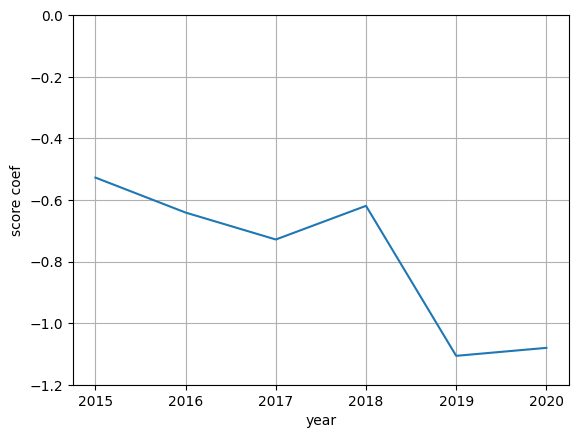

In [61]:
plt.plot(range(2015, 2021), score_coefs)
plt.ylim(-1.2, 0)
plt.xlabel('year')
plt.ylabel('score coef')
plt.yticks(np.arange(-1.2, 0.2, 0.2))
plt.grid()
plt.show()

In [62]:
accuracies = [0.5855513307984791, 0.6900664841611264, 0.6965408805031447, 0.6950253279646708, 0.738457603274076, 0.7306068601583113]

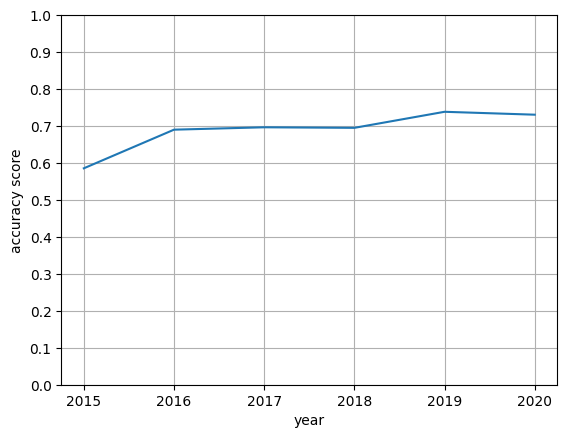

In [63]:
plt.plot(range(2015, 2021), accuracies)
plt.ylim(0, 1)
plt.xlabel('year')
plt.ylabel('accuracy score')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.show()

In [86]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report, accuracy_score

def get_combined_analysis(show_summary=False, show_accuracy=True):
    # Combine data for all years
    combined_df = spec_df[(spec_df['year'] >= 2015) & (spec_df['year'] <= 2020)].reset_index(drop=True)
    
    # Create interaction term
    combined_df['Score_before2017'] = combined_df['Score_norm'] * combined_df['before2017']
    
    x = combined_df[['Score_norm', 'before2017', 'male_specialization', 'female_specialization', 'general_competition', 'Score_before2017']].copy()
    y = combined_df['is_male']
    
    x_tr, x_t, y_tr, y_t = tts(x, y, test_size=0.2, random_state=105)
    
    neat_model = sm.Logit(y_tr, x_tr).fit(maxiter=1000, method='nm')
    
    if show_summary:
        y_pred_proba = neat_model.predict(x_t)
        y_pred = (y_pred_proba>=0.5).astype(int)
        print('test sample')
        print(classification_report(y_t, y_pred))
        y_pred_proba = neat_model.predict(x_tr)
        y_pred = (y_pred_proba>=0.5).astype(int)
        print('train sample')
        print(classification_report(y_tr, y_pred))
    
    if show_accuracy:
        y_pred_proba = neat_model.predict(x_t)
        y_pred = (y_pred_proba>=0.5).astype(int)
        print('test accuracy:', accuracy_score(y_t, y_pred))
    
    return neat_model

In [87]:
# Call the function
model = get_combined_analysis(show_summary=True, show_accuracy=True)

Optimization terminated successfully.
         Current function value: 0.590792
         Iterations: 418
         Function evaluations: 651
test sample
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     21076
           1       0.66      0.64      0.65     16167

    accuracy                           0.70     37243
   macro avg       0.69      0.69      0.69     37243
weighted avg       0.70      0.70      0.70     37243

train sample
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     84193
           1       0.66      0.63      0.65     64775

    accuracy                           0.70    148968
   macro avg       0.69      0.69      0.69    148968
weighted avg       0.70      0.70      0.70    148968

test accuracy: 0.7001047176650645


In [88]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_male   No. Observations:               148968
Model:                          Logit   Df Residuals:                   148962
Method:                           MLE   Df Model:                            5
Date:                Fri, 31 May 2024   Pseudo R-squ.:                  0.1371
Time:                        06:35:24   Log-Likelihood:                -88009.
converged:                       True   LL-Null:                   -1.0199e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Score_norm               -0.8726      0.022    -40.300      0.000      -0.915      -0.830
before2017                0.4661      0.105      4.452      0.000       0.261       0.671
male_specialization       1.0295      0.013     79.279      0.000       1.004       1.055
female_specialization    -1.1543      0.016    -72.090      0.000      -1.186      -1.123
general_competition       0.2315      0.015     15.501      0.000       0.202       0.261
Score_before2017         -0.3455      0.123     -2.800      0.005      -0.587      -0.104
=========================================================================================
"""